## 1. Create the full dataframe again

This is a new Jupyter page, it does not know about what we did in the other frames (unless you ran those on the same Jupyter already), so we here read in the data files again and recreate the full integrated dataframe

In [1]:
import json
import pandas as pd

# Load in the data files we generated - note that you can always update these by running
# one of the previous cells. Make sure you keep a copy of the original though, just in case
# things go wrong

#
# The csv file from uniprot
#
fileName = "proteins.tab"
proteinData = pd.read_csv(fileName, sep="\t").set_index("Entry").sort_index()

#
# The predictions from DynaMine, ...
#
dynaminePredFile = 'predictions.json'
file = open(dynaminePredFile, 'r')
input = file.read()
dynamineRawData = json.loads(input)
# Reorganising this data bit to make it easier to use
dynaMineData = {}
dynaMineValueTypes = ['disoMine', 'backbone', 'sidechain', 'earlyFolding']
for dynaMineValueType in dynaMineValueTypes:
    dynaMineData[dynaMineValueType] = {}
    
for resultDict in dynamineRawData['results']:
    proteinID = resultDict['proteinID']
    removeNonePositions = []
    for dynaMineValueType in dynaMineValueTypes:
        dynaMineData[dynaMineValueType][proteinID] = resultDict[dynaMineValueType]
        
        for i in range(len(resultDict[dynaMineValueType])):
            if resultDict[dynaMineValueType][i] == None:
                if i not in removeNonePositions:
                    removeNonePositions.append(i)
    
    removeNonePositions.reverse()
    for i in removeNonePositions:
        for dynaMineValueType in dynaMineValueTypes:
            dynaMineData[dynaMineValueType][proteinID].pop(i)


#
# The biopython data
#
bioPythonFile = 'bioPython.json'
file = open(bioPythonFile, 'r')
input = file.read()
bioPythonData = json.loads(input)

#
# The sequence distance data - is not used here because it relates to two proteins at the
# same time (is a matrix, essentially)
#
seqDistanceFile ='seqDistances_1.json'
file = open(seqDistanceFile, 'r')
input = file.read()
seqDistData = json.loads(input)


# The uniprot identifiers are shared, so we can use that to add information to the pandas dataframe
# from uniprot. We can in fact store most information in there, except for the sequence distance matrix,
# which we will have to treat differently.

# This gets the keys from the pandas dataframe
uniprotKeys = proteinData.index.values.tolist()

# We add first the data from disoMine/dynaMine, then biopython
for dictToAdd in (dynaMineData,bioPythonData):
    
    # These are the data labels for each dataset
    dataLabels = dictToAdd.keys()
    print(dataLabels)
    
    # We enter the data into the saveframe per data type
    for dataLabel in dataLabels:
        dataList = []
        
        # We get the data per uniprot ID, in the same order as in the pandas dataframe, to
        # create a list of values
        for uniprotKey in uniprotKeys:
            dataList.append(dictToAdd[dataLabel][uniprotKey])
        
        # We then add this list of values to the pandas dataframe, and now have the data available in there
        proteinData[dataLabel] = dataList

dict_keys(['disoMine', 'backbone', 'sidechain', 'earlyFolding'])
dict_keys(['aminoAcidNumbers', 'aminoAcidFractions', 'molecularWeights', 'aromaticity', 'instability', 'isoelectricPoint', 'flexibility', 'helixFraction', 'sheetFraction', 'coilFraction'])


## 2. More plotting and analysing with Python

6770 6770
0
(-0.4715153869073134, 0.0)
KruskalResult(statistic=6.8694413401415, pvalue=0.07617761751355423)


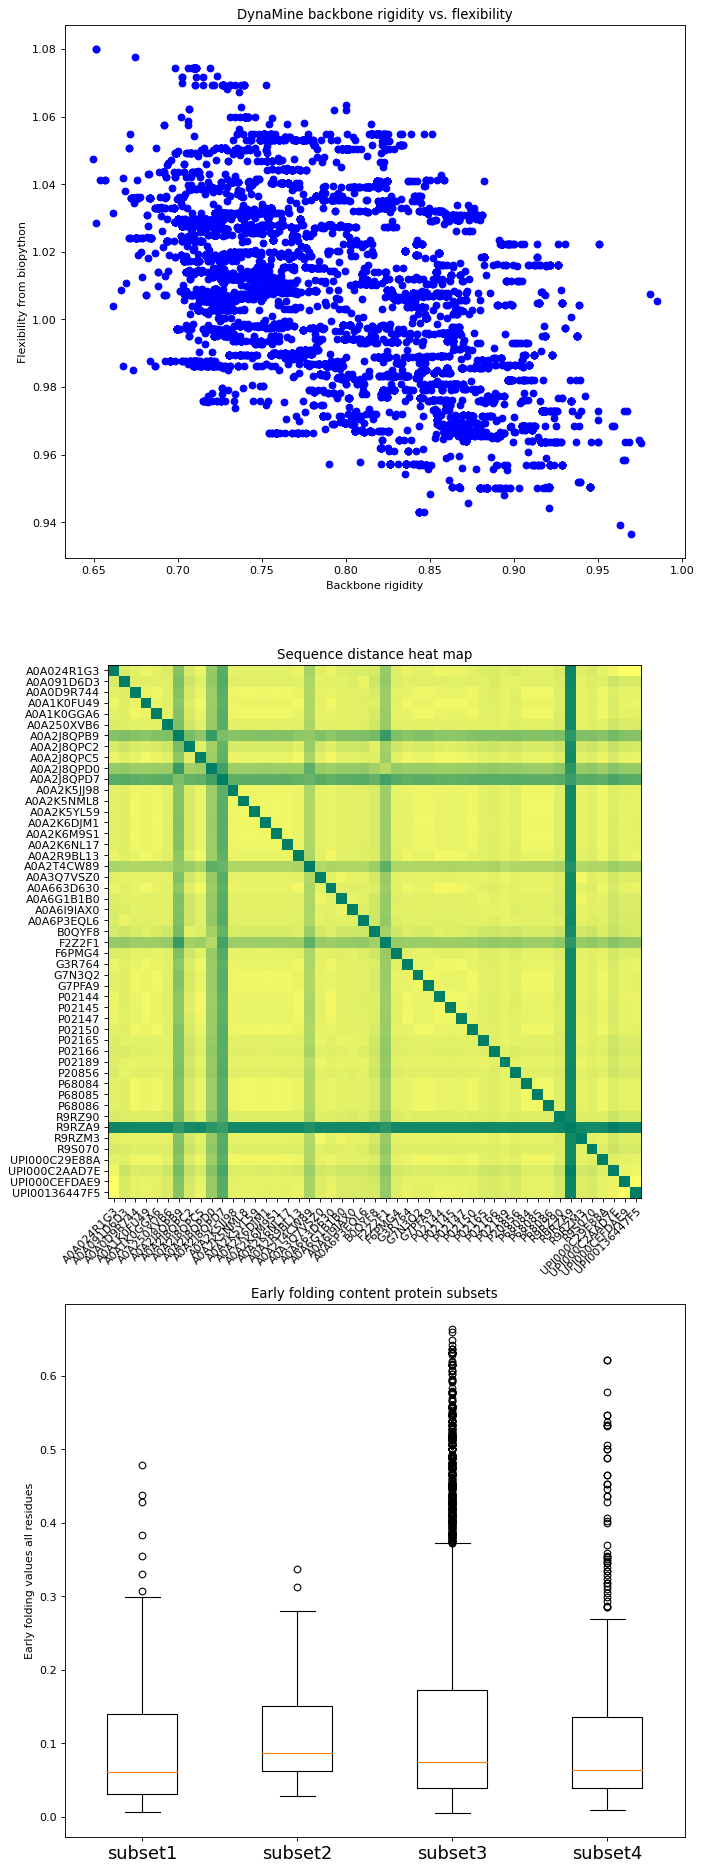

In [2]:
import scipy.stats as stats
import numpy
import matplotlib.pyplot as plt

# 
# Make a large plot to put subplots into
# 

fig = plt.figure(figsize=(10, 30), dpi= 80, facecolor='w', edgecolor='k')

#
# 1. Check the per-residue dynamine backbone values against the biopython flexibility
#    Here the problem is that 9 values are missing in the biopython code, the first 5 and last 4 residues
#

allDynaMineValues = []
for dynaMineValueList in proteinData['backbone'].values.tolist():
    allDynaMineValues.extend(dynaMineValueList[5:-4])
    
allFlexibilityValues = sum(proteinData['flexibility'].values.tolist(),[])

print(len(allDynaMineValues),len(allFlexibilityValues))
print(allDynaMineValues.count(None))

# Add a subplot to the main plot - see matplotlib documentation online for more examples/info
# should you want to customise this
axes = fig.add_subplot(311)
# Make a scatter plot
axes.scatter(allDynaMineValues, allFlexibilityValues, color="b") 
axes.set_title("DynaMine backbone rigidity vs. flexibility")
axes.set_xlabel("Backbone rigidity")
axes.set_ylabel("Flexibility from biopython")

#
# You can see that higher disorder corresponds to lower backbone rigidity (more flexibility)
# It's also possible to calculate the correlation and p-value on this with the numpy package
# From that value you can see that we can be sure of this correlation (low p-value) while
# there is a negative correlation (higher rigidity, lower disorder!)
#

print(stats.pearsonr(allDynaMineValues,allFlexibilityValues))

#
# 2. Heat map of the sequence distances
#

axes = fig.add_subplot(312)

# First make pandas matrix, convert to numpy, send to matplotlib
distanceMatrix_pandas = pd.DataFrame()

# Make sure we stick to the correct uniprot ID order!
for uniprotID1 in uniprotKeys:
    dataValues = []
    for uniprotID2 in uniprotKeys:
        if uniprotID1 == uniprotID2:
            value = 0
        else:
            value = seqDistData[uniprotID1][uniprotID2]
        dataValues.append(value)
        
    distanceMatrix_pandas[uniprotID1] = dataValues

distanceMatrix_numpy = distanceMatrix_pandas.to_numpy()

axes.imshow(distanceMatrix_numpy, cmap='summer', interpolation='nearest')
axes.set_title("Sequence distance heat map")
axes.set_xticks(numpy.arange(len(uniprotKeys)))
axes.set_yticks(numpy.arange(len(uniprotKeys)))
axes.set_xticklabels(uniprotKeys)
axes.set_yticklabels(uniprotKeys)
plt.setp(axes.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

#
# 3. Check the distribution of the helix content for two subsets of proteins
#    These subsets might come from clustering of the distances between sequences, for example, or from
#    another subset (e.g. isoelectric point)
#

# These subsets of protein ID lists you have to generete yourself based on clustering, via SPSS or via a label such as organism
proteinID_subset1 = ['A0A2J8QPD7']  # Here put your own subset of IDs based on clustering!
proteinID_subset2 = ['R9RZA9']
proteinID_subset3 = ['P02166','P02150','P02165','P02189','P68084','P68086','P68085','P02147','P20856','P02145','A0A024R1G3','A0A1K0FU49','B0QYF8','A0A2K6NL17','R9RZM3','A0A3Q7VSZ0','A0A6P3EQL6','A0A6I9IAX0','F6PMG4','A0A250XVB6','A0A1K0GGA6','G7N3Q2','G7PFA9','A0A2K6DJM1','R9S070','A0A2K5NML8','A0A0D9R744','A0A2K5YL59','A0A2K6M9S1','A0A2K5JJ98','G3R764','R9RZ90','A0A6G1B1B0','A0A091D6D3','A0A663D630','A0A2J8QPC5','A0A2R9BL13','A0A2J8QPC2','UPI000C2AAD7E','UPI000C29E88A','UPI00136447F5','UPI000CEFDAE9'] #Add the correct labels from the SPSS file here, Stephanie! 
proteinID_subset4 = ['F2Z2F1','A0A2J8QPD0','A0A2T4CW89','A0A2J8QPB9']

# Here now a comparison of the early folding values between the two subsets
ef_subset1 = sum([proteinData.loc[proteinID]['earlyFolding'] for proteinID in proteinID_subset1],[])
ef_subset2 = sum([proteinData.loc[proteinID]['earlyFolding'] for proteinID in proteinID_subset2],[])
ef_subset3 = sum([proteinData.loc[proteinID]['earlyFolding'] for proteinID in proteinID_subset3],[])
ef_subset4 = sum([proteinData.loc[proteinID]['earlyFolding'] for proteinID in proteinID_subset4],[])

# We now make a list of these separate lists in order to plot it in matplotlib
distributionData = [ef_subset1,ef_subset2,ef_subset3,ef_subset4]

axes = fig.add_subplot(313)
# This adds a boxplot
axes.boxplot(distributionData)
axes.set_title("Early folding content protein subsets")
axes.set_ylabel("Early folding values all residues")
# Here we label the boxplots on the x-axis
axes.set_xticklabels(['subset1','subset2','subset3','subset4'],fontsize=16)

#
# We can also compare their distributions with many tests, here using a Mann-Whitney non-parametric test
#

print(stats.kruskal(ef_subset1,ef_subset2,ef_subset3,ef_subset4))

